# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Introduction and Problem Definition
In Today's competition world, it is very difficult for a business to retain the customer. However, it is only possible by understand the customer well in advance and delight them with their experience. In a digital music service business(Sparkify), it is important to understand the users preference and suggest them accordingly to have a better experience. In order to provide the suggestions, it is important to understand the users behavior and needs a lot of analysis to judge the users behavior and recommend the best. The better your recommendation then the better user experience. 

Usually, Sparkify wants to keep their users at paid level. Since users leave some signs before they unsucscribe or cancel the subscribtion, we need to understand the data patters of the users and provide the the best service. The loss of users/customers means user or customer churn. 

The objective of the Sparkify company is to degtect the users cancellation decision before it happens and provide them with the better offers in order to retain them and in other words reduce the churn rate. 

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce

# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# TO load saved models 
from pyspark.ml.tuning import CrossValidatorModel as mlm

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# To find null USerIds using spark command
df.filter(df.userId == '').count()

8346

In [5]:
# To find null SessionIds using spark command
df.filter(df.sessionId == '').count()

0

In [6]:
# Delete the null User IDs
df = df.filter(df.userId != '')

In [7]:
# To confirm null USerIds are deleted using spark command
df.filter(df.userId == '').count()

0

In [8]:
# Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
# To see the nulls in all the columns
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
dtypes: float64(1), int64(5), object(12)
memory usage: 38.2+ MB


In [10]:
# To explore more about the data
dfp.describe()

,itemInSession,length,registration,sessionId,status,ts
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [11]:
# Exploring the Categoric variables
dfp.level.unique(), dfp.method.unique(), dfp.page.unique(), dfp.status.unique(), dfp.gender.unique(), dfp.auth.unique()

(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
        'Add Friend', 'Settings', 'Submit Upgrade', 'About',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F'], dtype=object),
 array(['Logged In', 'Cancelled'], dtype=object))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# How many users are present in the dataset?
df.select('userId').dropDuplicates().count()

225

In [13]:
# Churn is a label for the cancelled users
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Applying to the dataframe
df = df.withColumn("churn", flag_cancelation_event("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [14]:
# Again define pandas df for better view
dfp = df.toPandas()
dfp.tail(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
278151,None,Logged In,Delaney,F,21,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Roll Advert,1534627466000,53,None,200,1538498073000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1
278152,None,Logged In,Delaney,F,22,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,Cancel,1534627466000,53,None,307,1538498074000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1
278153,None,Cancelled,Delaney,F,23,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Cancellation Confirmation,1534627466000,53,None,200,1538498205000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1


In [15]:
# To Know continuing and cancelled users by pandas
dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [16]:
# To check unique by spark
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [17]:
# Exploring user status by gender
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



In [18]:
# Exploring user status by paid level
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|   36|
|    1| free|   46|
|    0| free|  149|
|    0| paid|  129|
+-----+-----+-----+



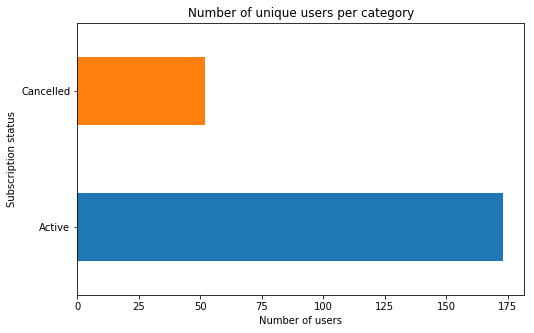

In [19]:
def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
    ax = dfp.drop_duplicates(subset=subset).groupby(
                                group)['userId'].count().plot(
                                kind='barh', figsize=(8,5), 
                                title='Number of unique users per category');
    ax.set_xlabel(x_title);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(y_title);

# Plot to check    
plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

Observation: It is observed that around 22% of users have been cancelled

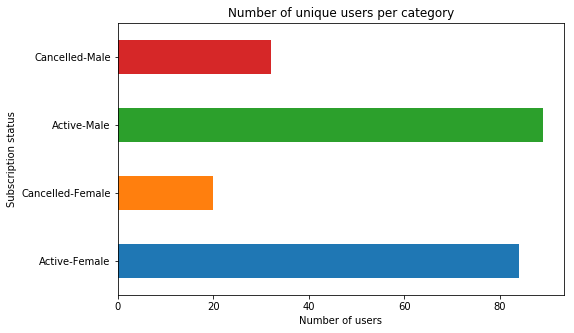

In [20]:
# To check at Gender level cancellation
plot_frequency(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

Observation: It shows that males are cancelling more than female users

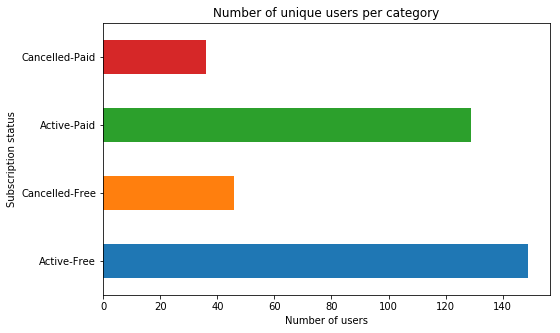

In [21]:
# To check at membership level
plot_frequency(['userId', 'level'], 
               ['level', 'churn'], 
               ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

Observation: It shows that the paid or free membership users are not influencing termination of the account since they both have same cancellation ratio.

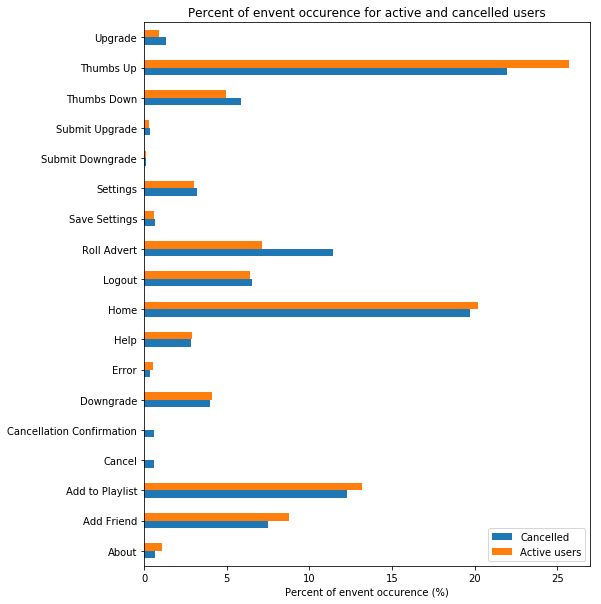

In [22]:
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

Observation: It shows that the most important pages visited for cancelling users are 
Roll Advert, and Thumbs Down (i.e., directly proportion to cancelling probability), while "Thumbs Up" followed by "Add Friend" and "Add to Playlist" are good indicators for not cancelling the account.

#### Analyzing on the Time

In [23]:
# Definig user functions to get hour, day, month, and weekday of cancellation

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [24]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))
    print(f'Column {label} added successfully.')

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [25]:
# To use pandas for a better visuals
dfp = df.toPandas()
dfp.sample(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
122002,Amy Winehouse,Logged In,Emilia,F,59,House,129.72363,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,I Heard Love Is Blind,200,1540442731000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011,0,4,25,10,4
149114,None,Logged In,Piper,F,108,Nielsen,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,...,None,307,1540909313000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",103,1,14,30,10,2
125863,Robin McKelle,Logged In,Emily,F,68,Fisher,193.17506,free,"Syracuse, NY",PUT,...,Something's Gotta Give,200,1540975381000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,100004,0,8,31,10,3


In [26]:
def get_series(col, churn, normalize=False):
    ''' 
    Get a series either of churn users or existing users
    THe function can normalize the series and return a percent value
    col: {str} the column to plot (hour, month, day, week_day)
    churn: {int} 0 or 1
    normalize: {bool} T/F, Default is False
    return a sorted pandas series
    '''
    ser1 = dfp[dfp.churn == churn].groupby([col])['userId'].count()
    try:
        ser1.index = ser1.index.astype(int)
    except:
        pass
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

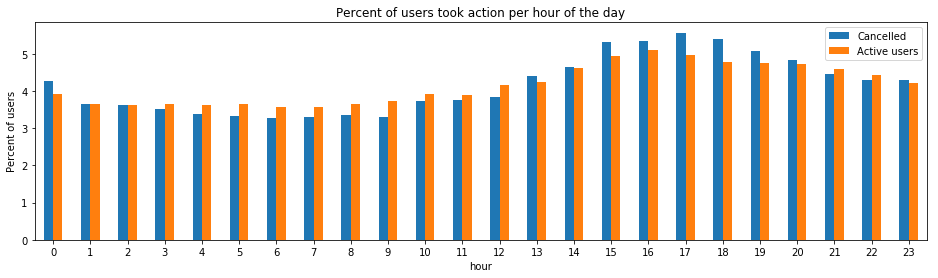

In [27]:
def draw_time(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    '''
    Draw a bar plot for churn and existing users based on 
         a specific column (hour, month, day, week_day)
         
    normalize: {bool} T/F, Default is True
    figsize: {tuple} the plot size, default is (16,4)
    title: descriptive title part
    Returns: None
    '''
    df_time = pd.DataFrame({'Cancelled': get_series(col, 1, normalize),
                            'Active users':get_series(col, 0, normalize)})
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
    if title is None:
        title = col
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

draw_time('hour', title='hour of the day');

Observation: It appears that cancelled users are more active between 13:00 and 20:00

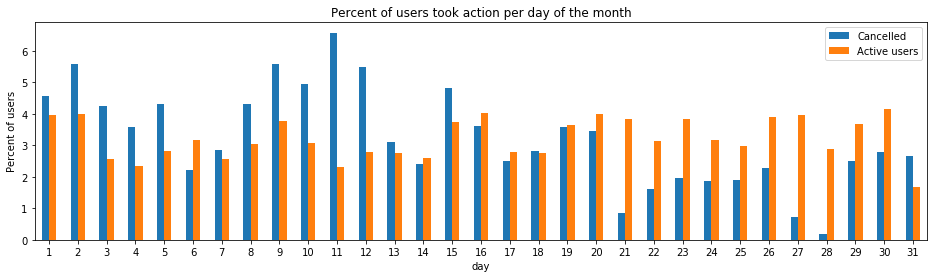

In [28]:
draw_time('day', title='day of the month');

Observation: Users are cancalling at different days of a month and it must be when their renewal date is closer.

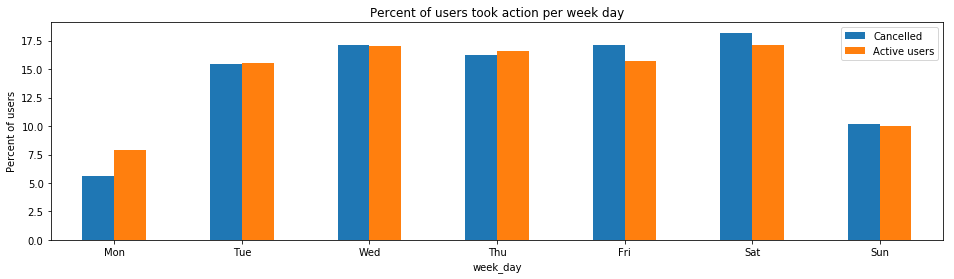

In [29]:
ax = draw_time('week_day', title='week day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0);

Observation: It shows that on Friday and Saturday, the churn users are more active and the remaining users are more active on Monday. The remaining days have no noticable difference between users' types.

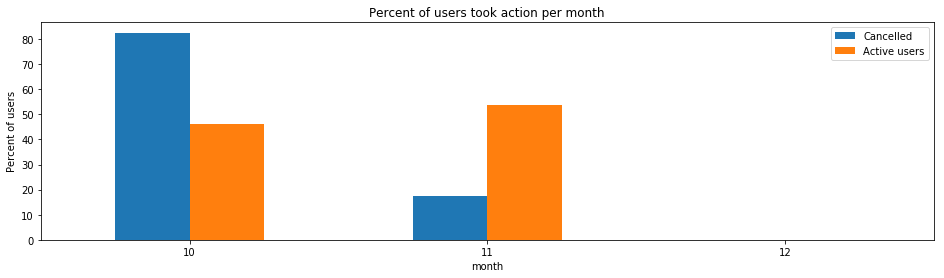

In [30]:
draw_time('month');

Observation: Monthly level data is not enough to judge the pattern

#### Analyzing on the Categorical variables

To understand more on the Operating System:

In [31]:
dfp.userAgent.unique().shape[0]

56

In [32]:
agents = [x.strip() for x  in dfp.userAgent.unique()] 
# sample
[agents[x] for x in [0, 2, 4, 10]]

['"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 '"Mozilla/5.0 (iPad; CPU OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D201 Safari/9537.53"']

In [33]:
# TO get the data between parenthesis and distinguish the data clearly
ex = '\(([^\)]*)\)'

# all OSs
sorted(list(set([re.findall(
    ex, x)[0].split(';')[0].capitalize(
) for x  in agents])))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [34]:
# To create mappers for the os
mapper_general = {'Compatible': 'Windows',  'Ipad': 'Mac',  'Iphone': 'Mac',  
          'Macintosh': 'Mac',  'Windows nt 5.1': 'Windows',  
          'Windows nt 6.0': 'Windows',  'Windows nt 6.1': 'Windows',  
          'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows',  
          'X11': 'Linux'}
mapper_specific = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  
          'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  
          'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  
          'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1',  
          'X11': 'Linux'}
print(sorted(list(set([mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))),
sorted(list(set([mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()] for x  in agents]))))

['Linux', 'Mac', 'Windows'] ['Linux', 'MacOS', 'Windows 7', 'Windows 8.0', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'iPad', 'iPhone']


In [35]:
# To define user defined functions
os_general = udf(lambda x: mapper_general[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_general", os_general(df.userAgent))

os_specific = udf(lambda x: mapper_specific[re.findall(ex, x)[0].split(';')[0].capitalize()])
df = df.withColumn("os_specific", os_specific(df.userAgent))

To understand more on the Location:

In [36]:
dfp.location.unique().shape[0]

114

In [37]:
states = set([state[1].strip() for state in [x.split(',') for x in dfp.location.unique()]])
len(states)

58

In [38]:
# To define a user defined function
get_state = udf(lambda x: x.split(',')[1].strip())
df = df.withColumn("state", get_state(df.location))

In [39]:
# To convert to pandas for better visuals
dfp = df.toPandas()
dfp.sample(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userAgent,userId,churn,hour,day,month,week_day,os_general,os_specific,state
250589,Jamie Foxx featuring T-Pain,Logged In,Saul,M,136,Johnson,289.74975,paid,"Houston-The Woodlands-Sugar Land, TX",PUT,...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,62,0,3,9,11,5,Windows,Windows 7,TX
252126,The Meters,Logged In,Sophia,F,61,Perry,185.96526,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) G...,12,1,22,16,10,2,Windows,Windows 8.1,CA
125605,None,Logged In,Emily,F,25,Fisher,NaN,paid,"Syracuse, NY",PUT,...,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,100004,0,13,18,10,4,Windows,Windows 7,NY


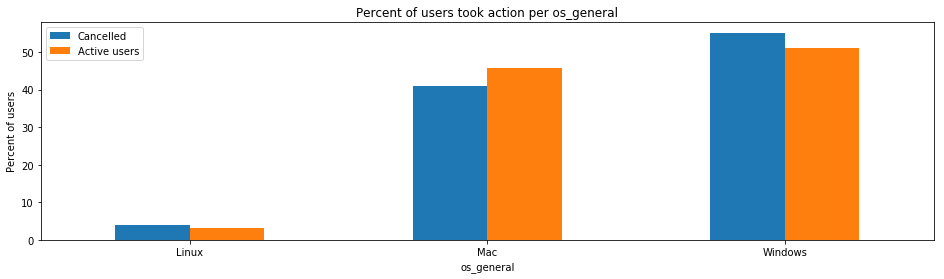

In [40]:
draw_time('os_general');

Observation: It shows that cancelled users ratio are lesser than the active users from Mac OS compared to windows and linux OS.

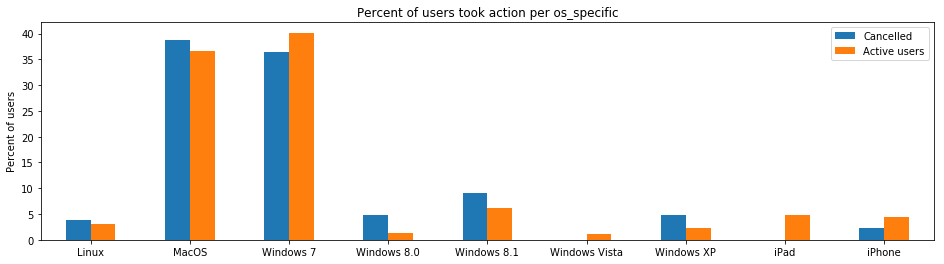

In [41]:
draw_time('os_specific');

Observation: It shows that more satisfied users ratio are from ipad, iphone, Windows vista, and Windows 7.

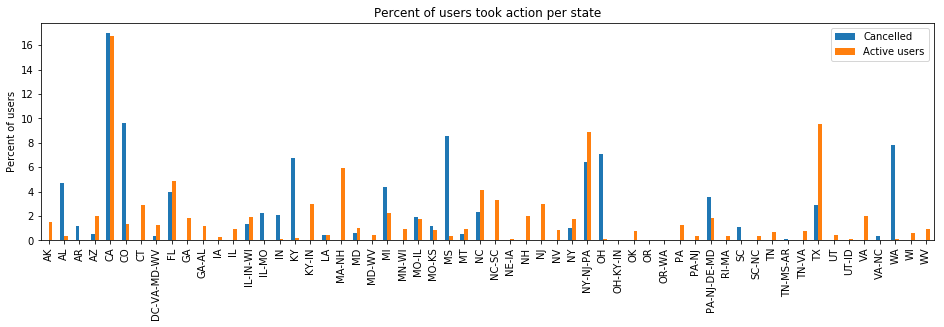

In [42]:
draw_time('state', label_rotation=90);

Observation: Some of the states have more cancelled users, which affects the user behavior. It might be due to the lifestyle or cultural difference between the states.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Overview

There are many featurs to keep,
1. Categoric features (needs to be converted to numeric form through dummi encoding)

  - Gender of user
  - The user's OS `os_specific`
  - (may be) the `state` he/she lives in
  - The payment level (Paid/Free)
  - (may be) the top `artist` the user listined to.
 
2. Numeric features

  - Song `length` per user per session
  - Number of ThumbsUp
  - Number of ThumbsDown
  - Number of InviteFriends
  - Number of downgrades
  - Number of songs per session
  - Number of artists the user fans
  - Session's duration
  - Sessions' count per user
  - The user's subscription age
  - Number of days as free/paid user
  
 Need to create a dataset with Churn and no Churn for the ML

In [43]:
churn_users = df.select('userId', 'churn').dropDuplicates()

# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [44]:
# Getting dummy variables for Gender

def create_dummy_df (col, dictionary):
    '''
    Create a dataframe to map a variable
    col: the column name
    dictionary: the mapping of from->to numeric values
    return a dataframe of 2 columns
    '''
    # To map M and F to numeric values, we first should map to string numbers (to avoid spark error)
    col_df = df.select('userId', col).dropDuplicates().replace(dictionary, subset=col)
    # Then convert the result to numeric value
    col_df = col_df.select('userId', col_df[col].cast('int'))
    # Check
    print(col_df.printSchema(), col_df.show(3))
    return col_df


gender_df = create_dummy_df('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows

None None


In [45]:
# Creating dummies for OS
os_titles =  df.select('os_specific').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [sF.when(sF.col('os_specific') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_titles]
os_df = df.select('userId', *os_expr)
os_df.show(10)

+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|userId|OS_iPad|OS_iPhone|OS_Windows 8.1|OS_Linux|OS_Windows Vista|OS_Windows 8.0|OS_MacOS|OS_Windows XP|OS_Windows 7|
+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       

In [46]:
# creating dummies for level

level_df = create_dummy_df('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
+------+-----+
only showing top 3 rows

None None


In [47]:
# Number of artists in the dataset
dfp.artist.unique().shape[0]

17656

In [48]:
# To get mean and SD per user
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(3)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000


In [49]:
# To get the Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, ...
# I think it is better to get all actions except Chorn actions (Cancel, cancelation confirmation)
# The to normalize them as percent to sum all to 100.

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# SOURCES
# https://stackoverflow.com/questions/47641076/spark-normalize-each-row-of-a-dataframe
# https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe

# the columns to be summed
pages_cols = user_page_distribution.columns[1:]

# adding a total column
new_df = user_page_distribution.withColumn('total', sum(user_page_distribution[col] for col in pages_cols))

# Applying normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_distribution = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_distribution.toPandas().head(5)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.0,0.21097,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.0,0.00000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.0,0.00000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.0,0.00000,0.849741,3.544041,0.000000


In [50]:
# number of changing songs per session
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)
song_user_df.show(3)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
+------+------------------+------------------+
only showing top 3 rows



In [51]:
# Number of artists the user fans
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(3)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
+------+----------+
only showing top 3 rows



In [52]:
# Session Duration

session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [53]:
# Get Average, and Standard deviation of the session duration per user

session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



In [54]:
# Sessions count per user
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(3)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
+------+------------+
only showing top 3 rows



In [55]:
# users' subscription age
def days_since_subscription(df, col_name='days_on'):
    # timestamp of users registration
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(3)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
+------+-----------------------+
only showing top 3 rows



In [56]:
# number of days as free or paid user
df_paid = df.filter(df.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(3)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
+------+----------------------+
only showing top 3 rows



In [57]:
df_free = df.filter(df.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(3)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
+------+----------------------+
only showing top 3 rows



In [58]:
paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(3)

+------+-----------------+-----------------+
|userId|     free_percent|     paid_percent|
+------+-----------------+-----------------+
|200002|22.48062015503876|77.51937984496125|
|100010|            100.0|              0.0|
|   125|            100.0|              0.0|
+------+-----------------+-----------------+
only showing top 3 rows



In [59]:
# It is enough to have either Paid or free percentage
paid_free_df = paid_free_df.drop('free_percent')
paid_free_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



In [60]:
# the features to collect
user_features = [gender_df, os_df, paid_free_df, song_length, 
                   user_page_distribution, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'os_df', 'paid_free_df', 'song_length', 
                   'user_page_distribution', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']


In [61]:
# Initialize the final_df
final_df = churn_users

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('*** COMPLETED ***')

Preparing features of the gender_df dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the os_df dataframe; the new frame's dimensions is: 225 * 12
Preparing features of the paid_free_df dataframe; the new frame's dimensions is: 225 * 13
Preparing features of the song_length dataframe; the new frame's dimensions is: 225 * 15
Preparing features of the user_page_distribution dataframe; the new frame's dimensions is: 225 * 32
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 225 * 34
Preparing features of the artists_user_fans dataframe; the new frame's dimensions is: 225 * 35
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 225 * 37
Preparing features of the num_sessions_user_df dataframe; the new frame's dimensions is: 225 * 38
Preparing features of the reg_df dataframe; the new frame's dimensions is: 225 * 39
*** COMPLETED ***


In [66]:
# Saving as SPARK format
final_df.write.save('user_dataset.CSV', format='csv', header=True)

In [67]:
final_dfp = final_df.toPandas()
final_dfp.head(3)

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,10,0,1,0,0,0,0,0,0,1,...,0.503145,4.654088,0.000000,112.166667,133.324291,566,7.662454,8.991061,6,51.762650
1,100,0,1,0,0,0,0,0,0,0,...,0.840075,4.604854,0.031114,78.882353,74.057621,1706,5.275317,5.133618,35,64.873773
2,100001,1,0,0,0,0,0,0,0,1,...,1.081081,4.324324,1.081081,33.250000,16.839933,126,2.469306,1.051126,4,44.800220


In [68]:
final_dfp.to_csv('user_dataset_pd.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [69]:
final_df = spark.read.csv('user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()
pfinal_df.head()

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,30,0,1,0,0,0,0,0,0,0,...,0.9577464788732395,3.492957746478873,0.7887323943661971,50.607142857142854,68.92579976333879,1019,3.0599045138888887,4.655638231407505,32,63.06664351851852
1,300001,1,0,0,0,0,0,0,0,0,...,0.7848568790397045,6.832871652816251,0.09233610341643582,102.88235294117646,88.12908313444346,1202,6.367543859649123,6.150871757879998,19,188.3117824074074
2,91,0,1,0,0,1,0,0,0,0,...,0.7962840079628402,4.11413404114134,0.033178500331785,286.6666666666667,337.84426885770904,1619,19.665,23.019357929090734,9,116.02526620370371
3,92,0,0,1,0,0,0,0,0,0,...,0.9958506224066389,4.0387275242047025,0.06915629322268327,70.77380952380952,86.9796197137792,2905,4.745203488372092,6.054084867345142,86,83.52885416666666
4,200008,0,0,0,0,0,0,0,0,0,...,2.584493041749503,3.3797216699801194,0.049701789264413515,111.26666666666667,107.38613016763829,1160,7.5379259259259275,7.284556907097743,15,115.18381944444444


In [70]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- OS_iPad: string (nullable = true)
 |-- OS_iPhone: string (nullable = true)
 |-- OS_Windows 8.1: string (nullable = true)
 |-- OS_Linux: string (nullable = true)
 |-- OS_Windows Vista: string (nullable = true)
 |-- OS_Windows 8.0: string (nullable = true)
 |-- OS_MacOS: string (nullable = true)
 |-- OS_Windows XP: string (nullable = true)
 |-- OS_Windows 7: string (nullable = true)
 |-- paid_percent: string (nullable = true)
 |-- mean_hours: string (nullable = true)
 |-- stdev_hours: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll 

In [71]:
# Change the column names to strings without spaces
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df.columns)

['userId', 'churn', 'gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 'paid_percent', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_aritst', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


In [72]:
# Convert all to numbers as the schema shows strings
# the first column (userId) would be integer
final_df = final_df.withColumn('userId', final_df.userId.cast(sT.IntegerType()))
# All columns from Churn to OS_* should be integer types
for col in final_df.columns[1:12]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.IntegerType()))
# All other columns should be float
for col in final_df.columns[12:]:
    final_df = final_df.withColumn(col, final_df[col].cast(sT.FloatType()))

final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- OS_iPad: integer (nullable = true)
 |-- OS_iPhone: integer (nullable = true)
 |-- OS_Windows_81: integer (nullable = true)
 |-- OS_Linux: integer (nullable = true)
 |-- OS_Windows_Vista: integer (nullable = true)
 |-- OS_Windows_80: integer (nullable = true)
 |-- OS_MacOS: integer (nullable = true)
 |-- OS_Windows_XP: integer (nullable = true)
 |-- OS_Windows_7: integer (nullable = true)
 |-- paid_percent: float (nullable = true)
 |-- mean_hours: float (nullable = true)
 |-- stdev_hours: float (nullable = true)
 |-- About: float (nullable = true)
 |-- Add_Friend: float (nullable = true)
 |-- Add_to_Playlist: float (nullable = true)
 |-- Downgrade: float (nullable = true)
 |-- Error: float (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Ad

In [73]:
# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [74]:
# Get features labels for plotting purposes
features_labels = final_df.columns[2:]

In [75]:
# The input features are all but the userId and the Churn
# The output is Churn only

# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df.columns[2:], outputCol='features')

# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df)
input_data.show(1)

+------+-----+------+-------+---------+-------------+--------+----------------+-------------+--------+-------------+------------+------------+----------+-----------+----------+----------+---------------+----------+-----------+----------+--------+---------+---------+-----------+-------------+----------+----------------+--------------+-----------+---------+---------+----------+-----------+----------+--------------+---------------+------------+-----------------------+--------------------+
|userId|churn|gender|OS_iPad|OS_iPhone|OS_Windows_81|OS_Linux|OS_Windows_Vista|OS_Windows_80|OS_MacOS|OS_Windows_XP|OS_Windows_7|paid_percent|mean_hours|stdev_hours|     About|Add_Friend|Add_to_Playlist| Downgrade|      Error|      Help|    Home|   Logout| NextSong|Roll_Advert|Save_Settings|  Settings|Submit_Downgrade|Submit_Upgrade|Thumbs_Down|Thumbs_Up|  Upgrade|mean_songs|stdev_songs|num_aritst|mean_session_h|stdev_session_h|num_sessions|days_total_subscription|            features|
+------+-----+----

In [76]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [77]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [78]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.80, 0.20], seed=179)
train.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.0762390990345...|
|    0|[-1.0762390990345...|
|    0|[-1.0762390990345...|
+-----+--------------------+
only showing top 3 rows



In [79]:
test.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.0762390990345...|
|    0|[-1.0762390990345...|
|    0|[-1.0762390990345...|
+-----+--------------------+
only showing top 3 rows



#### Defining the important functions for the analysis

In [80]:
def format_duration (t_dif):
    t_s = t_dif.seconds
    duration = {}
    duration['h'], rem = divmod(t_s, 3600) 
    duration['m'], duration['s'] = divmod(rem, 60)
    stamp = ''
    if duration['h']>0:
        stamp += f"{duration['h']} hour(s), " 
    if duration['m']>0:
        stamp += f"{duration['m']} minute(s) and "
    # seconds and fraction of seconds
    frac = int(t_dif.microseconds/10000)/100
    stamp += f"{duration['s'] + frac} second(s)"
    # print(f"{duration['h']}h:{duration['m']}m:{duration['s']}s")
    return stamp

In [81]:
def model_fitting(data, model_type, param_grid, save_as, num_folds=3, random_seed=179):
    '''
    
    
    '''
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=num_folds, seed=random_seed)
    t_start = pd.tslib.Timestamp.now()
    print ('Fitting in progress...', end=' ')
    fitted_model = model_evaluator.fit(data)
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    t_start = pd.tslib.Timestamp.now()
    print (f'\nSaving the model as {save_as}...' , end=' ')
    try:
        fitted_model.save(save_as)
    except:
        # Overwrite if exists
        fitted_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    return fitted_model

In [82]:
def get_formated_metrics(selected_model, test_data):
    '''
    Prints a compacted dataframe with all the model's metrics
    selected_model: The fitted model
    test_data: the test data portion
    '''
    def get_model_metrics(selected_model, model_type = 'train'):
        '''
        Get the metrics of a model
        selected_model:  the fitted model
        model_type: either 'train' (default) or 'test'
        '''
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
        else: 
            metrics = selected_model
        acc = metrics.accuracy, 
        general = np.array((metrics.weightedFMeasure(),
                   metrics.weightedPrecision, metrics.weightedRecall,
                   metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labeled = np.array((metrics.fMeasureByLabel(),
                          metrics.precisionByLabel, metrics.recallByLabel,
                          metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))
        conc_results = np.concatenate((general.T, labeled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
        df_res = pd.DataFrame(conc_results, columns=labels, index=metrics_names)
        return acc[0], df_res
    
    # Apply for training data
    acc_train, train_res = get_model_metrics(selected_model)
    # Get the results of the test data
    model_test = selected_model.bestModel.evaluate(test_data)
    # Apply on test data
    acc_test, test_res = get_model_metrics(model_test, model_type='test')
    
    # Concatenate to a pretty dataframe
    pretty_frame = pd.concat([train_res, test_res], axis=1, keys=[
                    f'Training (Accuracy = {acc_train*100:4.2f}%)',
                    f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    return pretty_frame

In [83]:
def draw_features_contribution(fitted_model, x_labels, scale_to='full_range'):
    '''
    Draws a bar chart of features vs churn %
    fitted_model: the fitted model
    scale_to: the values will be scated to:
           'full_range' where the full absolute values are summed to 100.
           'maximum_range' where the maximum absolute extremes are scalled to 100.
           'none' the values are shown as is.
    '''
    cmx = fitted_model.bestModel.coefficientMatrix
    cmv = cmx.values
    # cmv.shape, len(final_df.columns[2:])
    
    # Define positive and negative values
    positives_v = np.array([x if x>=0 else 0 for x in cmv])
    negatives_v = np.array([x if x<=0 else 0 for x in cmv])    
    
    # Drawing by scalling the maximum range to  100
    if scale_to == 'full_range':
        rang = positives_v.sum()+ abs(negatives_v).sum()
    elif scale_to == 'maximum_range':
        rang = positives_v.max()+ abs(negatives_v).max()
    else:
        rang = 1.
        
    positives_v /= rang
    negatives_v /= rang
    positives_v *= 100.
    negatives_v *= 100.
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positives_v,color='r')
    ax.bar(x_labels, negatives_v, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = final_df.columns[2:], rotation='vertical');

In [84]:
def get_classifier_metrics(trained_model, train_data, test_data):
    '''
    
    '''
    def get_specific_metrics(trained_model, data):
        '''
        
        '''
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)

In [85]:
def draw_features_importance(fitted_model, x_labels, threshold=0.1):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    # Get the threshold value
    thres_v = threshold / 100 
    # get the included and neglected values
    active_values = [x for x in importance if x >= thres_v]
    neglected = [x for x in importance if x < thres_v]
    non_zero_neglected = [x for x in neglected if x > 0]
    # print(importance, '\n', x_labels, '\n', thres_v, '\n', 
    #       active_values, '\n', neglected, '\n', non_zero_neglected)
    # get the accepted indexes
    active_idx = [importance.index(x) for x in active_values]
    # the accepted lables + minor features
    active_labels = [x_labels[x] for x in active_idx]
    minor_v = sum(neglected)
    # print(active_idx, '\n', active_labels, '\n', minor_v)
    # If there is any minor features
    if minor_v>0:
        active_values.append(minor_v)
        active_labels.append(f'MINOR, ({len( \
                non_zero_neglected)}feats. each<{threshold}%)')
    # print(active_labels, '\n', active_values)
    
    # sorting
    active_labels =[x for _, x in sorted(zip(active_values, active_labels))]
    active_values = sorted(active_values)
    
    # Draw

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active_values[::-1], labels=active_labels[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal');

### 1. Logistic Regression

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if __name__ == '__main__':


Fitting in progress... Done in 2 minute(s) and 48.46 second(s)

Saving the model as LogisticRegression.model... *Overwritten* Done in 2.04 second(s)


Training (Accuracy = 81.36%)                      \
                                    General Churn=0.0 Churn=1.0   
F-Measure                          0.758693  0.893204  0.266667   
Precision                          0.821507  0.811765  0.857143   
Recall                             0.813559  0.992806  0.157895   
True_+ve_Rate                      0.813559  0.992806  0.157895   
False_+ve_Rate                     0.662859  0.842105  0.007194   

               Testing (Accuracy = 72.92%)                      
                                   General Churn=0.0 Churn=1.0  
F-Measure                         0.660400  0.835443  0.235294  
Precision                         0.713889  0.733333  0.666667  
Recall                            0.729167  0.970588  0.142857  
True_+ve_Rate                     0.729167  0.970588  0.142857  
False_+ve_Rate                    0.615721  0.857143  0.029412

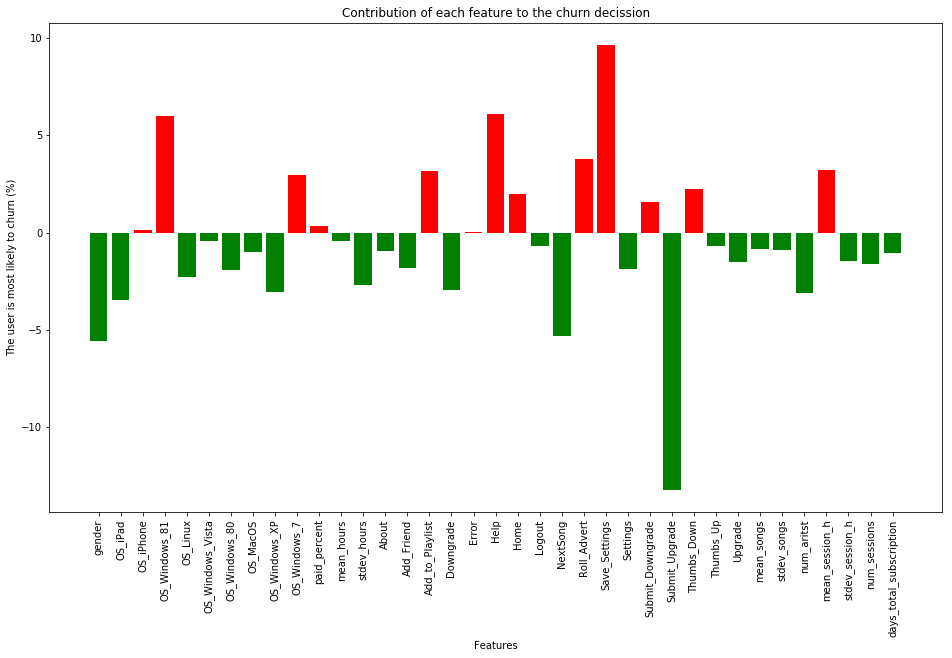

In [86]:
# The Logistic Regression model

model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()
# param_grid = ParamGridBuilder() \
#     .addGrid(model.aggregationDepth,[2, 5]) \
#     .build()
m = model_fitting(train, model, param_grid, 'LogisticRegression.model')
# Model metrics
display(get_formated_metrics(m, test))
# Features effect
draw_features_contribution(m, x_labels=features_labels)

### 2. Decision Tree Classifier

In [87]:
# The Decision Tree Classifier model

model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .build()

m = model_fitting(train, model, param_grid, 'DecisionTreeClassifier.model')

Fitting in progress... Done in 37.83 second(s)

Saving the model as DecisionTreeClassifier.model... *Overwritten* Done in 1.05 second(s)


In [88]:
# Uncomment if you want to load models only
features_labels = ['gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 
                   'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 
                   'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 
                   'paid_percent', 'mean_hours', 'stdev_hours', 
                   'About', 'Add_Friend', 'Add_to_Playlist', 
                   'Downgrade', 'Error', 'Help', 'Home', 'Logout', 
                   'NextSong', 'Roll_Advert', 'Save_Settings', 
                   'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 
                   'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 
                   'stdev_songs', 'num_aritst', 'mean_session_h', 
                   'stdev_session_h', 'num_sessions', 
                   'days_total_subscription']
len(features_labels)

37

In [89]:
# to load the model from saved location
m = mlm.load('DecisionTreeClassifier.model') 

In [90]:
get_classifier_metrics(m, train, test)

,Train,Test
Accuracy,0.841808,0.770833
Precision,0.619048,0.600000
Recall,0.684211,0.642857
F-Score,0.650000,0.620690


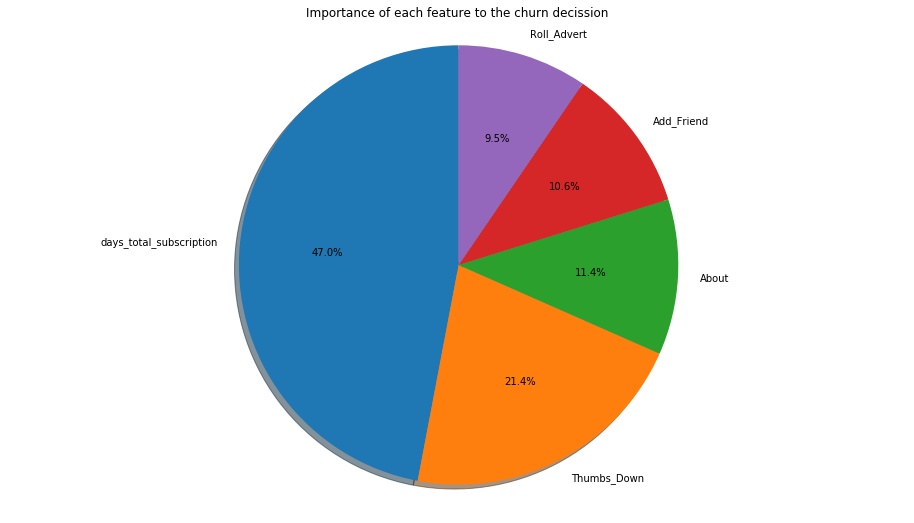

In [92]:
draw_features_importance(m, features_labels, threshold=3)

### 3. Gradient Boosted Trees

In [93]:
# The Gradient-Boosted Trees (GBTs) model

model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.maxIter ,[20, 5]) \
    .build()

m = model_fitting(train, model, param_grid, 'GradientBoostedTrees.model')

Fitting in progress... Done in 7 minute(s) and 15.01 second(s)

Saving the model as GradientBoostedTrees.model... *Overwritten* Done in 1.41 second(s)


In [94]:
# to load the model from saved location
m = mlm.load('GradientBoostedTrees.model') 
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.926554,0.770833
Precision,1.000000,0.666667
Recall,0.657895,0.428571
F-Score,0.793651,0.521739


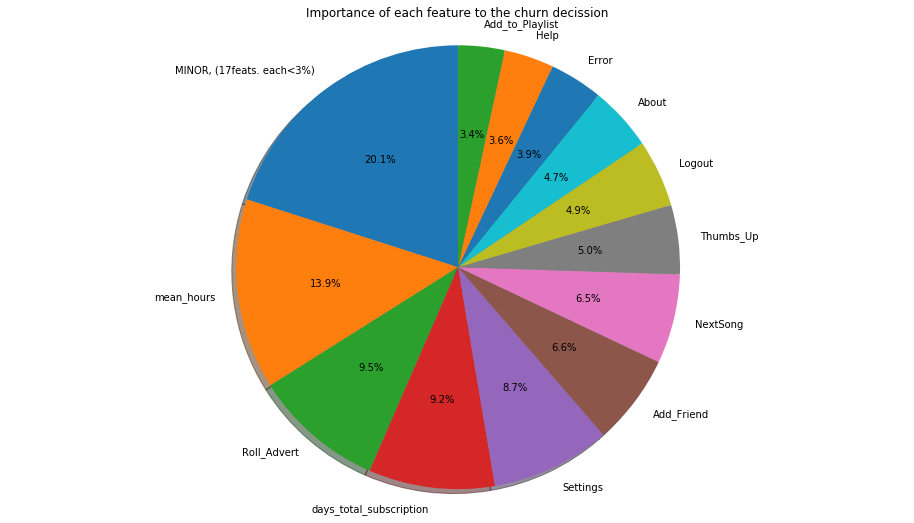

In [95]:
draw_features_importance(m, features_labels, threshold=3)

### 4.Random Forest

In [96]:
# The Random Forest model

model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.numTrees ,[20, 10]) \
    .addGrid(model.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

m = model_fitting(train, model, param_grid, 'RandomForestClassifier.model')

Fitting in progress... Done in 3 minute(s) and 6.29 second(s)

Saving the model as RandomForestClassifier.model... *Overwritten* Done in 1.65 second(s)


In [97]:
# to load the model from saved location
m = mlm.load('RandomForestClassifier.model') 

In [98]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,1.0,0.791667
Precision,1.0,1.000000
Recall,1.0,0.285714
F-Score,1.0,0.444444


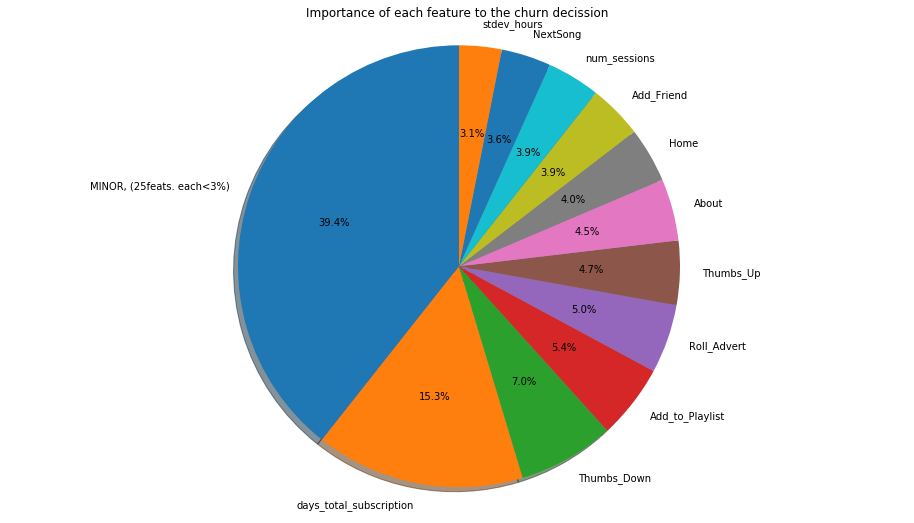

In [99]:
draw_features_importance(m, features_labels, threshold=3)

## Conclusion:

The models that we created using machine learning are effective in predicting the users, who will unsubscribe or cancel the service. Although all the models are better in predicting but Gradient boosted and Random forest models look like over fitting, therefore, decision tree classifier model looks better for me. The accuracy score of Decision tree classifier model to the train dataset is 84% and test dataset is 77%.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.